# MobileNet

<a id='top'.</a>
[Table of contents](#bot)

- [Initialization](#init)
- [Data augmentation](#da)
- [Modeling](#mod)
    - [Base model](#bm)
    - [Generating features](#gf)
    - [Top model](#tm)
    - [Setting alternative top models](#atm) 
    - [Training the whole model](#wm)
    - [Visualizing predictions](#pred)
    
[Table of contents](#top) [Bottom](#bot)
<a id='init'.</a>

## Initialization

In [1]:
import sys
sys.path.append('../utils/')

import libraries
from libraries import *
import utils_functions
from utils_functions import *

%matplotlib inline

reload(libraries)
from libraries import *
reload(utils_functions)
from utils_functions import *

# checking
print(get_available_gpus())
print(psutil.virtual_memory())
print(keras.__version__)

Using TensorFlow backend.


['/gpu:0']
svmem(total=64390926336, available=62915248128, percent=2.3, used=1183924224, free=46604996608, active=9000402944, inactive=7859998720, buffers=2152275968, cached=14449729536, shared=32239616)
2.0.6


#### Data loading: original and auxiliary data

In [2]:
model = 'mobilenet'

# output directories
output = '../output'
models = 'models'
model_output = join(join(output, models), model)
model_output_weights = join(model_output, 'weights')

if not os.path.exists(output): os.mkdir(output)
if not os.path.exists(model_output): os.mkdir(model_output)
if not os.path.exists(model_output_weights): os.mkdir(model_output_weights)
    
# general variables
target_size = (256, 256)
target_size_mn = (224, 224)
num_classes = 1
input_shape = target_size + (3,)
input_shape_mn = target_size_mn + (3,)

path='../../data/sushi_or_sandwich_aux/'

In [3]:
x_aux, y_aux, mean_aux, std_aux = \
load_data_aux(path=path, target_size=target_size_mn, output_folder=output, shuffle_c=True)
print(x_aux.shape, y_aux.shape, mean_aux, std_aux)

Loading compressed data..
(1520, 224, 224, 3) (1520,) 138.498 74.2337


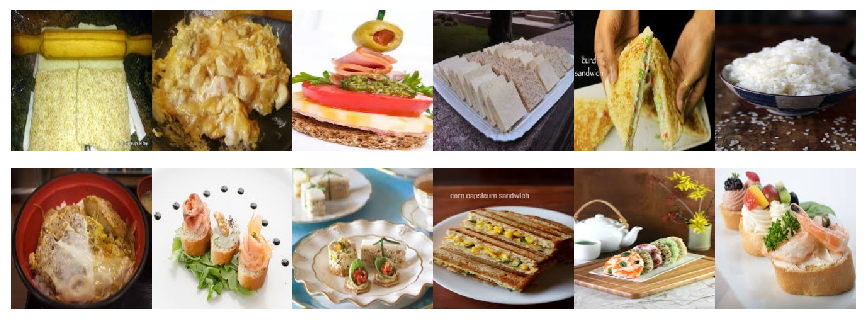

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [4]:
plot_images(x_aux[:12]); print(list(y_aux[:6])); print(list(y_aux[6:12]))

In [5]:
x_train, y_train, x_test, y_test, mean_set, std_set = \
load_data(path=path, target_size=target_size_mn, output_folder=output)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, mean_set, std_set)

Loading compressed data..
(640, 224, 224, 3) (640,) (160, 224, 224, 3) (160,) None None


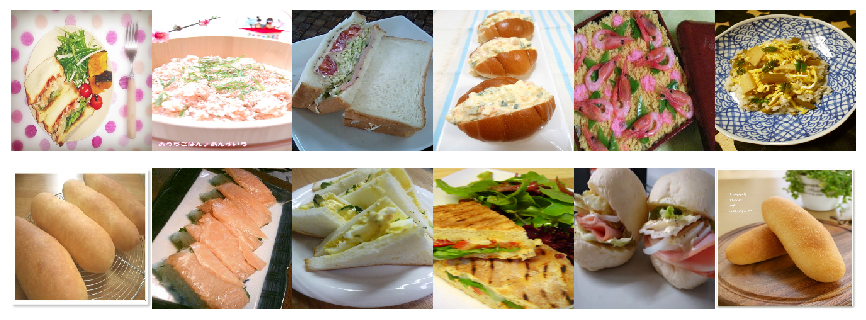

[0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [6]:
plot_images(x_train[:12]); print(list(y_train[:6])); print(list(y_train[6:12]))

##### merging both datasets while keeping untouched the held-out test set..

(2160, 224, 224, 3) (2160,) (160, 224, 224, 3) (160,) 137.068 73.5324


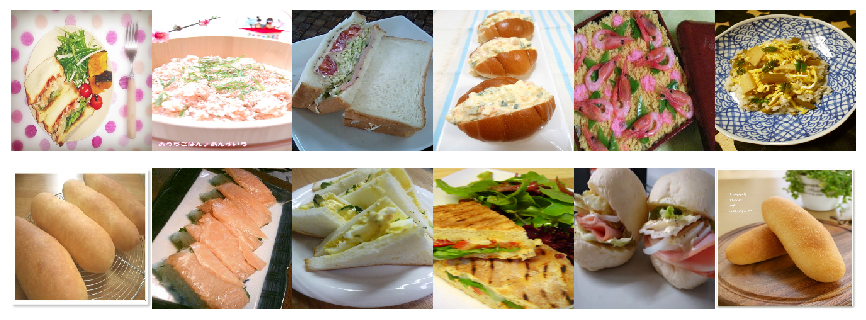

[0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [7]:
x_train_aux, y_train_aux, mean_set, std_set = \
shuffle_set(
    np.concatenate((x_aux, x_train), axis=0),
    np.concatenate((y_aux, y_train), axis=0))

print(x_train_aux.shape, y_train_aux.shape, x_test.shape, y_test.shape, mean_set, std_set)

plot_images(x_train[:12]); print(list(y_train[:6])); print(list(y_train[6:12]))

[Table of contents](#top) [Bottom](#bottom)
<a id='da'.</a>

## Data augmentation

The process of data augmentation is performed by the following function contained in utils.py. It generates a set of ~2000 different data augmentation generators by iterating over an customizable value range for the following parameters/functions provided by the keras within the DataImageGenerator class:
- rotation_range
- width_shift_range     
- height_shift_range      
- shear_range             
- zoom_range              
- channel_shift_range        
- zca_whitening
- fill_mode                  
- horizontal_flip
- vertical_flip

Additionally it performs cropping of the images through the 'preprocessing_function'.

An example  of the images produced by a randomly selected generator is shown below.

In [8]:
# 1. setting generators
n_gen = 100
ad_gens = aug_data_generators(model, n_gen)

# # 2. saving a 120-image sample and plotting a sample
# save_aug_data_sample(ad_gens, model, target_size_mn, path, output)

Total number of available aug. data generators:  288
Selected number of aug. data generators:  100


[Table of contents](#top) [Bottom](#bot)
<a id='mod'.</a>

## Modelling

<a id='bm'.</a>

##### 0.0. Setting the base model

In [9]:
input_shape = x_train.shape[1:]

bm = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape_mn)

<a id='gf'.</a>

##### 0.1. Generating features

In [10]:
# original data: calculates the output of the selected base model w/o data augmentation

data={'x_train':x_train, 'y_train':y_train, 'x_test':x_test, 'y_test':y_test}

x_f_train, y_f_train, x_f_test, y_f_test = \
generate_features(bm, data, model_output, iters=10, verbose=True, set_name='x10')

print(x_f_train.shape, y_f_train.shape, x_f_test.shape, y_f_test.shape)

Loading compressed features..
(6400, 7, 7, 1024) (6400,) (160, 7, 7, 1024) (160,)


In [21]:
# aux. data: calculates the output of the selected base model w/o data augmentation

data={'x_train':x_train_aux, 'y_train':y_train_aux, 'x_test':x_test, 'y_test':y_test}

x_f_train_aux, y_f_train_aux, x_f_test, y_f_test = \
generate_features(bm, data, model_output, iters=10, verbose=False, set_name='aux_x10')

print(x_f_train_aux.shape, y_f_train_aux.shape, x_f_test.shape, y_f_test.shape)

Processing features..
(21456, 7, 7, 1024) (21456,) (160, 7, 7, 1024) (160,)


In [17]:
# calculates the features/output of the selected base model with data augmentation

data={'x_train':x_train, 'y_train':y_train, 'x_test':x_test, 'y_test':y_test}

x_adf_train, y_adf_train, x_adf_test, y_adf_test = \
generate_aug_data_features(bm, ad_gens, data, model_output, batch_size=16, iters=1, verbose=False)

print(x_adf_train.shape, y_adf_train.shape, x_adf_test.shape, y_adf_test.shape)

Loading compressed features..


KeyboardInterrupt: 

In [18]:
for i in range(10):
#     x_f_train, y_f_train = shuffle_set(x_f_train, y_f_train, stats=False)
#     x_f_test, y_f_test = shuffle_set(x_f_test, y_f_test, stats=False)

    x_f_train_aux, y_f_train_aux = shuffle_set(x_f_train_aux, y_f_train_aux, stats=False)
    x_f_test_aux, y_f_test_aux = shuffle_set(x_f_test_aux, y_f_test_aux, stats=False)


[Table of contents](#top) [Bottom](#bot)
<a id='tm'.</a>

##### 0.2. Setting and training a top model

#### wo data augmentation

In [23]:
# dropout percentage
p = 0.5

top_m = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        GlobalAveragePooling2D(),
        Dropout(p),
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(p),
        Dense(1, activation='sigmoid')])

# top_m.summary()

top_m.load_weights(join(model_output_weights, 'woda_top_m_p50_0.5585_0.7500'))# 'aux_top_m_p50_0.3243_0.8568'))

top_m.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure])

# top_m.evaluate(x_adf_test, y_adf_test, batch_size=256)
top_m.evaluate(x_f_test, y_f_test, batch_size=256)

160/160 [==============================] - 0s


[0.55851978063583374, 0.75, 0.68918919563293457, 0.75, 0.71830981969833374]

In [20]:
top_m.optimizer.lr = 0.001; print(top_m.optimizer.lr)

batch_size = 256
epochs = 3

# top_m_h = top_m.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
#                     validation_data=(x_f_test, y_f_test))
#                     #callbacks=callbacks)

top_m_h = top_m.fit(x_f_train, y_f_train, batch_size=batch_size, epochs=epochs,                  
                    validation_data=(x_f_test, y_f_test))

0.001
Train on 6400 samples, validate on 160 samples
Epoch 1/3
6400/6400 [==============================] - 1s - loss: 0.6231 - acc: 0.6925 - recall: 0.7551 - precision: 0.7019 - fmeasure: 0.7182 - val_loss: 0.6019 - val_acc: 0.7188 - val_recall: 0.5000 - val_precision: 0.8222 - val_fmeasure: 0.6218
Epoch 2/3
6400/6400 [==============================] - 1s - loss: 0.3805 - acc: 0.8289 - recall: 0.8099 - precision: 0.8477 - fmeasure: 0.8277 - val_loss: 0.5717 - val_acc: 0.7125 - val_recall: 0.5811 - val_precision: 0.7414 - val_fmeasure: 0.6515
Epoch 3/3
6400/6400 [==============================] - 1s - loss: 0.3009 - acc: 0.8717 - recall: 0.8774 - precision: 0.8724 - fmeasure: 0.8741 - val_loss: 0.5730 - val_acc: 0.7125 - val_recall: 0.5946 - val_precision: 0.7333 - val_fmeasure: 0.6567


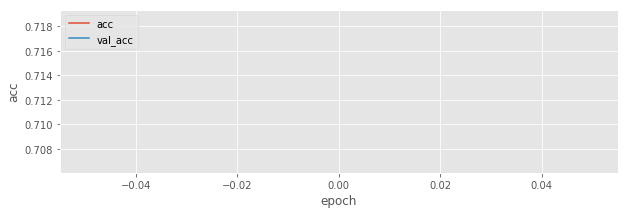

In [100]:
plot_hist(top_m_h, 'acc')

In [85]:
weights_file = 'woda_top_m_p%2d_%.4f_%.4f' % (p*100, top_m_h.history['val_loss'][-1], top_m_h.history['val_acc'][-1])
top_m.save_weights(join(model_output_weights, weights_file))

In [32]:
bm = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape_mn)
m = Model(bm.input, top_m(bm.output))

for layer in bm.layers: layer.trainable = False

m.compile(Adam(), loss='binary_crossentropy', 
          metrics=['accuracy', recall, precision, fmeasure])

m.load_weights(join(model_output_weights, 'woda_m_p50_0.2992_0.8812'))
m.evaluate(x_test, y_test, batch_size=256)

160/160 [==============================] - 1s


[0.29921963810920715,
 0.88125002384185791,
 0.86486488580703735,
 0.87671232223510742,
 0.87074828147888184]

In [33]:
m.optimizer.lr = 0.001; print(m.optimizer.lr)
batch_size = 128
epochs = 30

m_h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test))

0.001
Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 4s - loss: 0.0393 - acc: 0.9875 - recall: 0.9907 - precision: 0.9837 - fmeasure: 0.9872 - val_loss: 0.3033 - val_acc: 0.8875 - val_recall: 0.8859 - val_precision: 0.8760 - val_fmeasure: 0.8793
Epoch 2/30
640/640 [==============================] - 3s - loss: 0.0450 - acc: 0.9844 - recall: 0.9785 - precision: 0.9904 - fmeasure: 0.9844 - val_loss: 0.3109 - val_acc: 0.8938 - val_recall: 0.8859 - val_precision: 0.8882 - val_fmeasure: 0.8857
Epoch 3/30
640/640 [==============================] - 3s - loss: 0.0405 - acc: 0.9922 - recall: 1.0000 - precision: 0.9849 - fmeasure: 0.9924 - val_loss: 0.3087 - val_acc: 0.9000 - val_recall: 0.8859 - val_precision: 0.9010 - val_fmeasure: 0.8922
Epoch 4/30
640/640 [==============================] - 3s - loss: 0.0352 - acc: 0.9859 - recall: 0.9907 - precision: 0.9820 - fmeasure: 0.9863 - val_loss: 0.3131 - val_acc: 0.9062 - val_recall: 0.8859 - val_p

In [22]:
# unfreezing the last 3 convolutional blocks

for layer in bm.layers[:64]: layer.trainable = False
for layer in bm.layers[64:]: layer.trainable = True

In [30]:
m.optimizer.lr = 0.1; print(m.optimizer.lr)
batch_size = 128
epochs = 20

m_h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test))   

0.1
Train on 640 samples, validate on 160 samples
Epoch 1/20
640/640 [==============================] - 3s - loss: 0.0209 - acc: 0.9922 - recall: 0.9873 - precision: 0.9971 - fmeasure: 0.9922 - val_loss: 0.3311 - val_acc: 0.8938 - val_recall: 0.9007 - val_precision: 0.8795 - val_fmeasure: 0.8891
Epoch 2/20
640/640 [==============================] - 3s - loss: 0.0153 - acc: 0.9953 - recall: 0.9971 - precision: 0.9932 - fmeasure: 0.9951 - val_loss: 0.3379 - val_acc: 0.8938 - val_recall: 0.9007 - val_precision: 0.8795 - val_fmeasure: 0.8891
Epoch 3/20
640/640 [==============================] - 3s - loss: 0.0066 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - fmeasure: 1.0000 - val_loss: 0.3463 - val_acc: 0.8875 - val_recall: 0.8907 - val_precision: 0.8782 - val_fmeasure: 0.8829
Epoch 4/20
640/640 [==============================] - 3s - loss: 0.0260 - acc: 0.9891 - recall: 0.9885 - precision: 0.9905 - fmeasure: 0.9894 - val_loss: 0.3640 - val_acc: 0.8812 - val_recall: 0.8907 - val_pre

KeyboardInterrupt: 

In [ ]:
# unfreezing the last 5 convolutional blocks

for layer in bm.layers[:52]: layer.trainable = False
for layer in bm.layers[52:]: layer.trainable = True
    
m.optimizer.lr = 0.001; print(m.optimizer.lr)
batch_size = 128
epochs = 3

m_h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test)) 

In [25]:
weights_file = 'woda_m_p%2d_%.4f_%.4f' % (p*100, m_h.history['val_loss'][-1], m_h.history['val_acc'][-1])
m.save_weights(join(model_output_weights, weights_file))

#### wo data augmentation + aux data

In [38]:
# dropout percentage
p = 0.5

top_m_aux = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        GlobalAveragePooling2D(),
        Dropout(p),
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(p),
        Dense(1, activation='sigmoid')])

top_m_aux.load_weights(join(model_output_weights, 'aux_woda_top_m_p50_1.1835_0.6000'))

top_m_aux.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure])

top_m_aux.evaluate(x_f_test, y_f_test, batch_size=256)

160/160 [==============================] - 0s


[1.1835110187530518,
 0.60000002384185791,
 0.56756758689880371,
 0.56756758689880371,
 0.56756752729415894]

In [34]:
top_m_aux.optimizer.lr = 0.001; print(top_m_aux.optimizer.lr)

batch_size = 128
epochs = 150

# top_m_h = top_m.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
#                     validation_data=(x_f_test, y_f_test))
#                     #callbacks=callbacks)

top_m_aux_h = top_m_aux.fit(x_f_train_aux, y_f_train_aux, batch_size=batch_size, epochs=epochs,                  
                            validation_data=(x_f_test, y_f_test))

0.001
Train on 21456 samples, validate on 160 samples
Epoch 1/150
21456/21456 [==============================] - 3s - loss: 0.1541 - acc: 0.9416 - recall: 0.9421 - precision: 0.9424 - fmeasure: 0.9413 - val_loss: 0.9142 - val_acc: 0.6562 - val_recall: 0.6653 - val_precision: 0.6253 - val_fmeasure: 0.6407
Epoch 2/150
21456/21456 [==============================] - 3s - loss: 0.1424 - acc: 0.9479 - recall: 0.9480 - precision: 0.9487 - fmeasure: 0.9477 - val_loss: 0.9727 - val_acc: 0.6125 - val_recall: 0.6391 - val_precision: 0.5736 - val_fmeasure: 0.6026
Epoch 3/150
21456/21456 [==============================] - 3s - loss: 0.1330 - acc: 0.9509 - recall: 0.9515 - precision: 0.9514 - fmeasure: 0.9507 - val_loss: 0.9941 - val_acc: 0.6375 - val_recall: 0.5975 - val_precision: 0.6125 - val_fmeasure: 0.6028
Epoch 4/150
21456/21456 [==============================] - 3s - loss: 0.1342 - acc: 0.9498 - recall: 0.9479 - precision: 0.9523 - fmeasure: 0.9495 - val_loss: 1.0231 - val_acc: 0.6062 - val_

21456/21456 [==============================] - 3s - loss: 0.0581 - acc: 0.9817 - recall: 0.9820 - precision: 0.9821 - fmeasure: 0.9819 - val_loss: 1.1982 - val_acc: 0.6813 - val_recall: 0.6653 - val_precision: 0.6556 - val_fmeasure: 0.6577
Epoch 34/150
21456/21456 [==============================] - 3s - loss: 0.0549 - acc: 0.9815 - recall: 0.9813 - precision: 0.9820 - fmeasure: 0.9814 - val_loss: 1.1947 - val_acc: 0.6312 - val_recall: 0.6129 - val_precision: 0.6023 - val_fmeasure: 0.6036
Epoch 35/150
21456/21456 [==============================] - 3s - loss: 0.0578 - acc: 0.9800 - recall: 0.9803 - precision: 0.9803 - fmeasure: 0.9800 - val_loss: 1.1263 - val_acc: 0.6438 - val_recall: 0.6391 - val_precision: 0.6128 - val_fmeasure: 0.6224
Epoch 36/150
21456/21456 [==============================] - 3s - loss: 0.0554 - acc: 0.9804 - recall: 0.9815 - precision: 0.9797 - fmeasure: 0.9803 - val_loss: 1.1506 - val_acc: 0.6438 - val_recall: 0.6499 - val_precision: 0.6115 - val_fmeasure: 0.6276
E

21456/21456 [==============================] - 3s - loss: 0.0408 - acc: 0.9862 - recall: 0.9869 - precision: 0.9856 - fmeasure: 0.9861 - val_loss: 1.1995 - val_acc: 0.6250 - val_recall: 0.6237 - val_precision: 0.5933 - val_fmeasure: 0.6054
Epoch 66/150
21456/21456 [==============================] - 3s - loss: 0.0402 - acc: 0.9860 - recall: 0.9864 - precision: 0.9859 - fmeasure: 0.9860 - val_loss: 1.1624 - val_acc: 0.6125 - val_recall: 0.5559 - val_precision: 0.5889 - val_fmeasure: 0.5695
Epoch 67/150
21456/21456 [==============================] - 3s - loss: 0.0383 - acc: 0.9870 - recall: 0.9869 - precision: 0.9875 - fmeasure: 0.9871 - val_loss: 1.2055 - val_acc: 0.6500 - val_recall: 0.6499 - val_precision: 0.6200 - val_fmeasure: 0.6318
Epoch 68/150
21456/21456 [==============================] - 3s - loss: 0.0390 - acc: 0.9876 - recall: 0.9880 - precision: 0.9874 - fmeasure: 0.9876 - val_loss: 1.1980 - val_acc: 0.6375 - val_recall: 0.6237 - val_precision: 0.6140 - val_fmeasure: 0.6142
E

21456/21456 [==============================] - 3s - loss: 0.0320 - acc: 0.9887 - recall: 0.9884 - precision: 0.9891 - fmeasure: 0.9886 - val_loss: 1.3379 - val_acc: 0.6000 - val_recall: 0.5844 - val_precision: 0.5669 - val_fmeasure: 0.5733
Epoch 98/150
21456/21456 [==============================] - 3s - loss: 0.0291 - acc: 0.9903 - recall: 0.9906 - precision: 0.9903 - fmeasure: 0.9903 - val_loss: 1.2839 - val_acc: 0.6250 - val_recall: 0.6083 - val_precision: 0.5919 - val_fmeasure: 0.5995
Epoch 99/150
21456/21456 [==============================] - 3s - loss: 0.0337 - acc: 0.9893 - recall: 0.9893 - precision: 0.9893 - fmeasure: 0.9892 - val_loss: 1.3956 - val_acc: 0.6125 - val_recall: 0.6106 - val_precision: 0.5780 - val_fmeasure: 0.5921
Epoch 100/150
21456/21456 [==============================] - 3s - loss: 0.0312 - acc: 0.9900 - recall: 0.9902 - precision: 0.9898 - fmeasure: 0.9899 - val_loss: 1.2402 - val_acc: 0.6188 - val_recall: 0.5975 - val_precision: 0.5886 - val_fmeasure: 0.5906


21456/21456 [==============================] - 3s - loss: 0.0286 - acc: 0.9901 - recall: 0.9894 - precision: 0.9909 - fmeasure: 0.9901 - val_loss: 1.2938 - val_acc: 0.6125 - val_recall: 0.5559 - val_precision: 0.5889 - val_fmeasure: 0.5695
Epoch 130/150
21456/21456 [==============================] - 3s - loss: 0.0276 - acc: 0.9914 - recall: 0.9915 - precision: 0.9916 - fmeasure: 0.9914 - val_loss: 1.2724 - val_acc: 0.6125 - val_recall: 0.5690 - val_precision: 0.5857 - val_fmeasure: 0.5753
Epoch 131/150
21456/21456 [==============================] - 3s - loss: 0.0252 - acc: 0.9915 - recall: 0.9919 - precision: 0.9912 - fmeasure: 0.9915 - val_loss: 1.2526 - val_acc: 0.6375 - val_recall: 0.5821 - val_precision: 0.6158 - val_fmeasure: 0.5970
Epoch 132/150
21456/21456 [==============================] - 3s - loss: 0.0253 - acc: 0.9924 - recall: 0.9917 - precision: 0.9932 - fmeasure: 0.9924 - val_loss: 1.2684 - val_acc: 0.6188 - val_recall: 0.5821 - val_precision: 0.5912 - val_fmeasure: 0.584

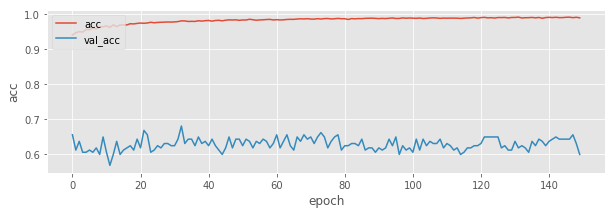

In [41]:
plot_hist(top_m_aux_h, 'acc')

In [37]:
weights_file = 'aux_woda_top_m_p%2d_%.4f_%.4f' % (p*100, top_m_aux_h.history['val_loss'][-1], top_m_aux_h.history['val_acc'][-1])
top_m_aux.save_weights(join(model_output_weights, weights_file))

In [74]:
bm = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape_mn)
m = Model(bm.input, top_m_aux(bm.output))

for layer in bm.layers: layer.trainable = False

m.compile(Adam(), loss='binary_crossentropy', 
          metrics=['accuracy', recall, precision, fmeasure])

m.load_weights(join(model_output_weights, 'aux_woda_m_p50_0.3034_0.8812'))
m.evaluate(x_test, y_test, batch_size=256)

160/160 [==============================] - 1s


[0.3033592700958252,
 0.88125002384185791,
 0.837837815284729,
 0.89855074882507324,
 0.86713284254074097]

In [69]:
m.optimizer.lr = 0.001; print(m.optimizer.lr)
batch_size = 128
epochs = 10

m_h = m.fit(x_train_aux, y_train_aux, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test))

0.001
Train on 2160 samples, validate on 160 samples
Epoch 1/10
2160/2160 [==============================] - 11s - loss: 0.0445 - acc: 0.9852 - recall: 0.9903 - precision: 0.9804 - fmeasure: 0.9852 - val_loss: 0.3021 - val_acc: 0.8812 - val_recall: 0.8367 - val_precision: 0.8948 - val_fmeasure: 0.8647
Epoch 2/10
2160/2160 [==============================] - 10s - loss: 0.0358 - acc: 0.9875 - recall: 0.9912 - precision: 0.9844 - fmeasure: 0.9876 - val_loss: 0.3025 - val_acc: 0.8750 - val_recall: 0.8367 - val_precision: 0.8812 - val_fmeasure: 0.8582
Epoch 3/10
2160/2160 [==============================] - 10s - loss: 0.0364 - acc: 0.9833 - recall: 0.9852 - precision: 0.9818 - fmeasure: 0.9832 - val_loss: 0.3073 - val_acc: 0.8812 - val_recall: 0.8367 - val_precision: 0.8948 - val_fmeasure: 0.8647
Epoch 4/10
2160/2160 [==============================] - 10s - loss: 0.0362 - acc: 0.9898 - recall: 0.9905 - precision: 0.9895 - fmeasure: 0.9899 - val_loss: 0.3112 - val_acc: 0.8812 - val_recall: 0

In [66]:
weights_file = 'aux_woda_m_p%2d_%.4f_%.4f' % (p*100, m_h.history['val_loss'][-1], m_h.history['val_acc'][-1])
m.save_weights(join(model_output_weights, weights_file))

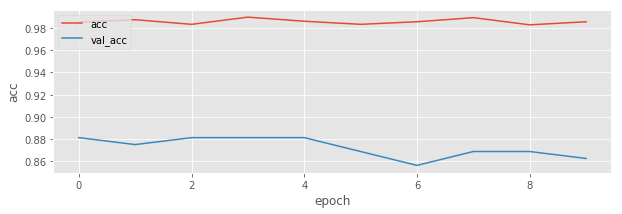

In [71]:
plot_hist(m_h, 'acc')

In [75]:
# unfreezing the last 3 convolutional blocks

for layer in bm.layers[:64]: layer.trainable = False
for layer in bm.layers[64:]: layer.trainable = True

# unfreezing the last 5 convolutional blocks

# for layer in bm.layers[:52]: layer.trainable = False
# for layer in bm.layers[52:]: layer.trainable = True

m.evaluate(x_test, y_test, batch_size=256)

160/160 [==============================] - 0s


[0.3033592700958252,
 0.88125002384185791,
 0.837837815284729,
 0.89855074882507324,
 0.86713284254074097]

In [95]:
m.optimizer.lr = 0.01; print(m.optimizer.lr)
batch_size = 256
epochs = 10

m_h = m.fit(x_train_aux, y_train_aux, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test))

0.01
Train on 2160 samples, validate on 160 samples
Epoch 1/10
2160/2160 [==============================] - 10s - loss: 0.0382 - acc: 0.9856 - recall: 0.9883 - precision: 0.9834 - fmeasure: 0.9857 - val_loss: 0.3024 - val_acc: 0.8813 - val_recall: 0.8378 - val_precision: 0.8986 - val_fmeasure: 0.8671
Epoch 2/10
2160/2160 [==============================] - 10s - loss: 0.0313 - acc: 0.9926 - recall: 0.9964 - precision: 0.9891 - fmeasure: 0.9928 - val_loss: 0.3026 - val_acc: 0.8813 - val_recall: 0.8378 - val_precision: 0.8986 - val_fmeasure: 0.8671
Epoch 3/10
2160/2160 [==============================] - 10s - loss: 0.0286 - acc: 0.9921 - recall: 0.9936 - precision: 0.9906 - fmeasure: 0.9920 - val_loss: 0.3025 - val_acc: 0.8813 - val_recall: 0.8378 - val_precision: 0.8986 - val_fmeasure: 0.8671
Epoch 4/10
2160/2160 [==============================] - 10s - loss: 0.0439 - acc: 0.9856 - recall: 0.9881 - precision: 0.9831 - fmeasure: 0.9856 - val_loss: 0.3023 - val_acc: 0.8813 - val_recall: 0.

In [92]:
weights_file = 'aux_woda_m_p%2d_%.4f_%.4f' % (p*100, m_h.history['val_loss'][-1], m_h.history['val_acc'][-1])
m.save_weights(join(model_output_weights, weights_file))

In [96]:
sys.path.append('../utils/densenet/')
import densenet121
from densenet121 import *

In [ ]:
dm = DenseNet()

END